<a href="https://colab.research.google.com/github/aeshna25/Detecting-and-Classifying-Chest-Disease/blob/main/Healthcare_use_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
XRay_Directory = '/content/drive/MyDrive/Data Science for Business Package/4. Operations Department/Dataset'

In [ ]:
os.listdir(XRay_Directory)

['3', '2', '1', '0']

In [ ]:
# image generation using tensor images data 
# perform normalization 

image_generator= ImageDataGenerator(1./255, validation_split=0.2) # 20% is used for cross validation (keep check on over-fiting)

1. Total # images= 133*4= 532
2. Training split (532*0.8)= 428
3. Testing/cross validation= (532*0.2)=104

In [ ]:
train_generator= image_generator.flow_from_directory(batch_size=40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode='categorical', subset='training')

Found 428 images belonging to 4 classes.


In [ ]:
validation_generator= image_generator.flow_from_directory(batch_size=40, directory=XRay_Directory, shuffle= True, target_size=(256,256), class_mode='categorical', subset='validation')

Found 104 images belonging to 4 classes.


In [ ]:
#generate and see some images
train_images , train_labels= next(train_generator)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
train_images.shape

(40, 256, 256, 3)

40 images with 256*256 pixels and 3 colors(rgb)

In [ ]:
train_labels.shape

(40, 4)

40 images and 4 classes

In [ ]:
train_labels

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]],

In [ ]:
# label translator: dictionary

label_names= {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

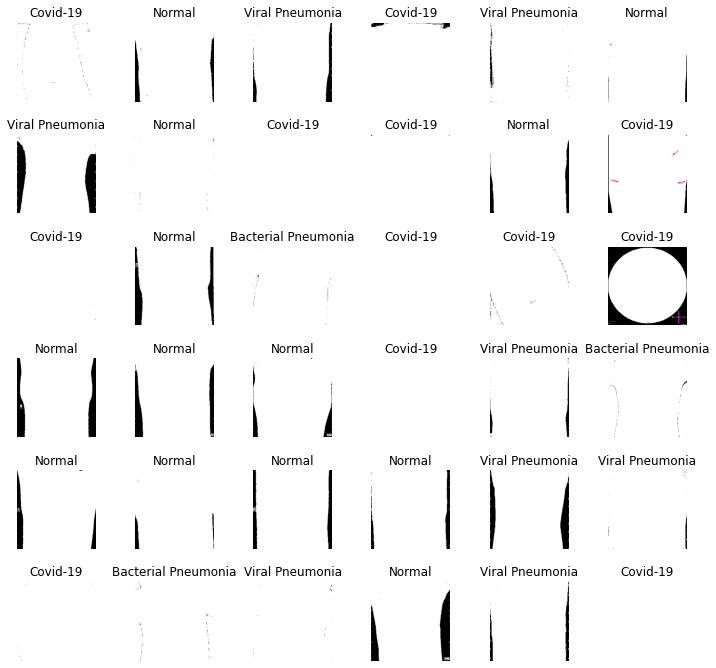

In [ ]:
#visualizating training set
L= 6
W=6

fig,axes= plt.subplots(L,W, figsize=(12,12))
axes= axes.ravel() # flatten 

for i in np.arange(0, L * W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)


In [ ]:
# transfer learning: transfer knowledge from pre trained model to a new model
# the initial convolutional layers are kept the same
# the last layers are changed depending upon the results required
# assumptions: both the tasks are kind of similar

basemodel= ResNet50(weights='imagenet', include_top=False, input_tensor= Input(shape=(256,256,3)))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# freezing initial layers

for layer in basemodel.layers[:-10]:
  layers.trainable=False 

In [ ]:
headmodel= basemodel.output
headmodel= AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel= Flatten(name='flatten')(headmodel)
headmodel= Dense(256, activation='relu')(headmodel) #relu output is continuous
headmodel= Dropout(0.3)(headmodel) #drop layer: generalization
headmodel= Dense(128, activation='relu')(headmodel)
headmodel= Dropout(0.2)(headmodel)
headmodel= Dense(4, activation='softmax')(headmodel) # softmax is categotical

In [ ]:
model= Model(inputs=basemodel.input, outputs= headmodel) #final model

In [ ]:
model.compile(loss= 'categorical_crossentropy', optimizer= optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'] )

In [ ]:
# check overfitting : early stopping
earlystopping= EarlyStopping(monitor='val_loss', mode='min', patience=20) # stop training after 20 epochs 

# save the best model with lower validation loss
checkpointer= ModelCheckpoint(filepath='weights.hdf5')



In [ ]:
train_generator= image_generator.flow_from_directory(batch_size=4, directory=XRay_Directory, shuffle=True,target_size=(256,256),class_mode='categorical', subset='training')
val_generator= image_generator.flow_from_directory(batch_size=4, directory=XRay_Directory, shuffle=True,target_size=(256,256),class_mode='categorical', subset='validation')


Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history= model.fit_generator(train_generator, epochs=5, validation_data= val_generator,callbacks=[checkpointer, earlystopping])

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


107/107 [==============================] - 395s 4s/step - loss: 0.0422 - accuracy: 0.9953 - val_loss: 1.1088 - val_accuracy: 0.9231
Epoch 2/5
107/107 [==============================] - 393s 4s/step - loss: 0.0312 - accuracy: 0.9930 - val_loss: 1.3749 - val_accuracy: 0.8750
Epoch 3/5
107/107 [==============================] - 393s 4s/step - loss: 0.0672 - accuracy: 0.9883 - val_loss: 2.7150 - val_accuracy: 0.8173
Epoch 4/5
107/107 [==============================] - 393s 4s/step - loss: 0.1134 - accuracy: 0.9860 - val_loss: 1.5661 - val_accuracy: 0.9135
Epoch 5/5
107/107 [==============================] - 392s 4s/step - loss: 0.1079 - accuracy: 0.9836 - val_loss: 1.1679 - val_accuracy: 0.9038


Red flag: Training accuracy is increasing with every epoch but validation accurancy isn't, that means there is overfitting in the model

## Experiment with infra

In [ ]:
headmodel= basemodel.output
headmodel= AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel= Flatten(name='flatten')(headmodel)
headmodel= Dense(256, activation='relu')(headmodel) 
headmodel= Dropout(0.3)(headmodel) 
headmodel= Dense(128, activation='relu')(headmodel)
headmodel= Dropout(0.2)(headmodel)
headmodel= Dense(256, activation='relu')(headmodel) #ADDED 
headmodel= Dropout(0.2)(headmodel) #ADDED 
headmodel= Dense(4, activation='softmax')(headmodel) 

In [ ]:
model= Model(inputs=basemodel.input, outputs= headmodel) 

In [ ]:
model.compile(loss= 'categorical_crossentropy', optimizer= optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'] )

In [ ]:
# check overfitting : early stopping
earlystopping= EarlyStopping(monitor='val_loss', mode='min', patience=30) # stop training after 30 epochs  ADDED

# save the best model with lower validation loss
checkpointer= ModelCheckpoint(filepath='weights.hdf5')

In [ ]:
train_generator= image_generator.flow_from_directory(batch_size=4, directory=XRay_Directory, shuffle=True,target_size=(256,256),class_mode='categorical', subset='training')
val_generator= image_generator.flow_from_directory(batch_size=4, directory=XRay_Directory, shuffle=True,target_size=(256,256),class_mode='categorical', subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping]) #ADDED

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


107/107 [==============================] - 407s 4s/step - loss: 0.1993 - accuracy: 0.9393 - val_loss: 0.4859 - val_accuracy: 0.8846
Epoch 2/10
107/107 [==============================] - 390s 4s/step - loss: 0.0292 - accuracy: 0.9953 - val_loss: 0.3508 - val_accuracy: 0.8942
Epoch 3/10
107/107 [==============================] - 393s 4s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4224 - val_accuracy: 0.9038
Epoch 4/10
107/107 [==============================] - 391s 4s/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.3624 - val_accuracy: 0.9519
Epoch 5/10
107/107 [==============================] - 394s 4s/step - loss: 0.0267 - accuracy: 0.9930 - val_loss: 2.2970 - val_accuracy: 0.7596
Epoch 6/10
107/107 [==============================] - 395s 4s/step - loss: 0.0502 - accuracy: 0.9930 - val_loss: 2.0938 - val_accuracy: 0.8462
Epoch 7/10
107/107 [==============================] - 392s 4s/step - loss: 0.0328 - accuracy: 0.9953 - val_loss: 1.6506 - val_accuracy: 0.8269
Epoch 8/10

After 10 epochs we can see, that the training accuracy as well as the validation accuracy both have an upward trend, which shows good fit of the model

## Performance

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'Training accuracy and loss')

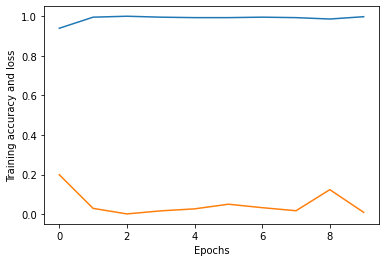

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training accuracy and loss')

Text(0, 0.5, 'Validation loss')

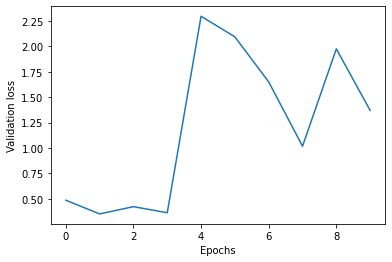

In [ ]:
plt.plot(history.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Validation loss')

Text(0, 0.5, 'Validation accuracy')

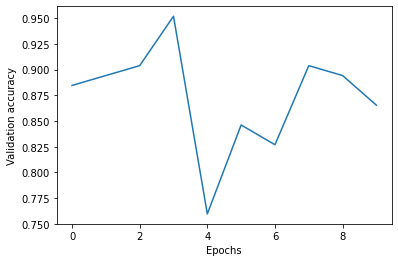

In [ ]:
plt.plot(history.history['val_accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')

In [ ]:
test_directory= '/content/drive/MyDrive/Data Science for Business Package/4. Operations Department/Test'

In [ ]:
test_gen= ImageDataGenerator(rescale=1./255)
test_generator= test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')
evaluate=  model.evaluate_generator(test_generator, steps=test_generator.n//4, verbose=1)
print('Accuracy Test : {}'.format(evaluate[1]))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
prediction=[]
original=[]
image=[]

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))): 
    img= cv2.imread(os.path.join(test_directory, str(i),item)) #read image
    img= cv2.resize(img, (256,256))  #resize
    image.append(img)
    img=img/255 #normalize image
    img= img.reshape(-1,256,256,3) #reshape image to needed pixels
    predict= model.predict(img) #make prediction
    predict= np.argmax(predict) 
    prediction.append(predict)
    original.append(i)


In [ ]:
score= accuracy_score(original, prediction)
print('Test accuracy: {}'.format(score))

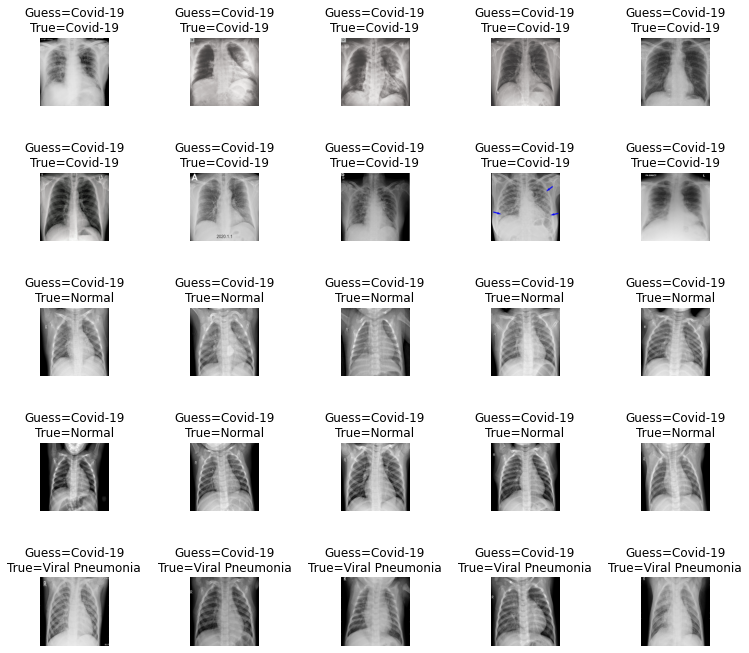

In [ ]:
L=5
W=5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 